In [105]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
using Sobol
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

compute_higher_derivs

In [6]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

# Summary
Settings parameters: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data

Tests:
1. p=3 or p=1, x=x2, x0=x02, test_fun1 \
   pdf blows up near 0, numerical issue (g'(y0) blows up when y0~=0?)
2. p=1, x=x3, x0=x03, test_fun1 \
    pdf weird shape (no peak, uniformish)
3. p=3, x=x3, x0=x03, test_fun1 \
    pdf blows up near 0, and pdf support ~= $[0,5]$
4. p=1, x=2, x0=x04, test_fun2 \
    pdf heavy near 0

In [7]:
# Data and setup for different tests

# choice of covariate functions
p = 1
# p = 3

# training
nx = 20
x1 = 4 .* rand(nx, 2) .- 2 
x2 = [-0.28340   0.62098;
     -1.59902   1.86275;
      0.49347  -1.46311;
      1.50624  -1.42874; 
      1.57966  -1.4987;  
     -1.35577   0.33419;
      1.57967   0.4927;  
      1.30226   1.30865; 
      1.84554  -1.71706; 
      1.45705   0.264961]
x3 = [-0.801151   -0.543169;   
      -0.94552     1.09677;    
       0.947512   -0.827147;   
      -1.42516     0.916257;   
      -1.35157     0.449443;   
       0.266677    1.31536;    
      -0.555493    0.841922;   
      -0.0235545   0.000649033;
      -0.339027    0.843967;   
      -1.7816      1.52251; ]

# testing
x01 = 4 .*rand(1, 2) .- 2
x02 = [-1.0097 0.3929]
x03 = [-0.936599  -1.94613]
x04 = [0.6368579322807415 0.5764428247722932]

# underlying 2d function 
test_fun1(x, y) = x^2 * exp(- x^2 - y^2) 
test_fun2(x, y) = sin(x^2 + y^2) + 1.1

test_fun2 (generic function with 1 method)

In [8]:
# parameter setting: change for different tests

p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x2 # choose training data 
x0 = x01 # choose testing data
test_fun = test_fun2 # choose underlying function

#####################################

# setup values and covariates (no changes needed)
Fx = covariate_fun(x, p)
y = [test_fun(_x[1], _x[2]) for _x in zip(x[:,1], x[:,2])]
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = test_fun(x0[1], x0[2])/ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")


Prediction at x0 = [-1.1767590454595496 0.7178765869217711]
Covariates at x0: [1.0]
Should expect peak near 1.0084914571101637


In [9]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 150]
rangeθ2 = [0.25 150; 0.25 150]
rangeλ = [0.2 3.]

1×2 Array{Float64,2}:
 0.2  3.0

In [106]:
btg1 = btg(trainingData1, rangeθ, rangeλ, quadtype = ["Gaussian", "Gaussian"]);
(pdf1, cdf1, dpdf1, quantInfo1) = solve(btg1);
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 

#1702 (generic function with 1 method)

In [35]:
btg2 = btg(trainingData1, rangeθ2, rangeλ, quadtype = ["Gaussian", "Gaussian"]);
(pdf2, cdf2, dpdf2, quantInfo2) = solve(btg2);
pdf_fixed2 = y0 -> pdf2(x0, Fx0, y0)
cdf_fixed2 = y0 -> cdf2(x0, Fx0, y0)
dpdf_fixed2 = y0 -> dpdf2(x0, Fx0, y0) 

#890 (generic function with 1 method)

In [36]:
btg3 = btg(trainingData1, rangeθ2, rangeλ; quadtype = ["MonteCarlo", "MonteCarlo"]);
(pdf3, cdf3, dpdf3, quantInfo3) = solve(btg3);
pdf_fixed3 = y0 -> pdf3(x0, Fx0, y0)
cdf_fixed3 = y0 -> cdf3(x0, Fx0, y0)
dpdf_fixed3 = y0 -> dpdf3(x0, Fx0, y0) 

#896 (generic function with 1 method)

In [37]:
btg4 = btg(trainingData1, rangeθ2, rangeλ; quadtype = ["MonteCarlo", "Gaussian"]);
(pdf4, cdf4, dpdf4, quantInfo4) = solve(btg4);
pdf_fixed4 = y0 -> pdf4(x0, Fx0, y0)
cdf_fixed4 = y0 -> cdf4(x0, Fx0, y0)
dpdf_fixed4 = y0 -> dpdf4(x0, Fx0, y0) 

#902 (generic function with 1 method)

In [38]:
btg5 = btg(trainingData1, rangeθ2, rangeλ; quadtype = ["QuasiMonteCarlo", "QuasiMonteCarlo"]);
(pdf5, cdf5, dpdf5, quantInfo5) = solve(btg5);
pdf_fixed5 = y0 -> pdf5(x0, Fx0, y0)
cdf_fixed5 = y0 -> cdf5(x0, Fx0, y0)
dpdf_fixed5 = y0 -> dpdf5(x0, Fx0, y0) 

#908 (generic function with 1 method)

In [39]:
btg6 = btg(trainingData1, rangeθ2, rangeλ; quadtype = ["QuasiMonteCarlo", "Gaussian"]);
(pdf6, cdf6, dpdf6, quantInfo6) = solve(btg6);
pdf_fixed6 = y0 -> pdf6(x0, Fx0, y0)
cdf_fixed6 = y0 -> cdf6(x0, Fx0, y0)
dpdf_fixed6 = y0 -> dpdf6(x0, Fx0, y0) 

#914 (generic function with 1 method)

# Statistics

In [107]:
include("test_quantile.jl")
include("../statistics.jl")

credible_interval (generic function with 3 methods)

In [108]:
# preprocess output from solve(btg)
pdf_fixed1, cdf_fixed1, dpdf_fixed1, quant01, support1 = pre_process(x0, Fx0, pdf1, cdf1, dpdf1, quantInfo1[1]);
println(btg1.quadType, " Estimated support of pdf: $support1")

# pdf_fixed2, cdf_fixed2, dpdf_fixed2, quant02, support2 = pre_process(x0, Fx0, pdf2, cdf2, dpdf2, quantInfo2[1]);
# println(btg2.quadType, " Estimated support of pdf: $support2")

# pdf_fixed3, cdf_fixed3, dpdf_fixed3, quant03, support3 = pre_process(x0, Fx0, pdf3, cdf3, dpdf3, quantInfo3[1]);
# println(btg3.quadType, " Estimated support of pdf: $support3")

# pdf_fixed4, cdf_fixed4, dpdf_fixed4, quant04, support4 = pre_process(x0, Fx0, pdf4, cdf4, dpdf4, quantInfo4[1]);
# println(btg4.quadType, " Estimated support of pdf: $support4")

# pdf_fixed5, cdf_fixed5, dpdf_fixed5, quant05, support5 = pre_process(x0, Fx0, pdf5, cdf5, dpdf5, quantInfo5[1]);
# println(btg5.quadType, " Estimated support of pdf: $support5")

# pdf_fixed6, cdf_fixed6, dpdf_fixed6, quant06, support6 = pre_process(x0, Fx0, pdf6, cdf6, dpdf6, quantInfo6[1]);
# println(btg6.quadType, " Estimated support of pdf: $support6")

["Gaussian", "Gaussian"] Estimated support of pdf: [0.01, 14.929919999999996]


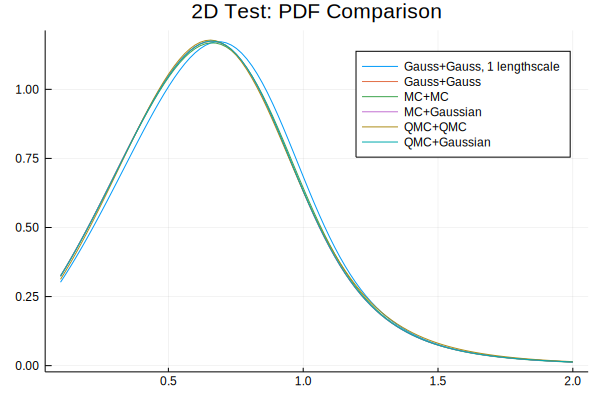

In [25]:
a = 0.1; b = 2
ygrid = range(a, b, length = 100)
pdf_plot = plot(ygrid, pdf_fixed1.(ygrid), label = "Gauss+Gauss, 1 lengthscale")
plot!(ygrid, pdf_fixed2.(ygrid), label = "Gauss+Gauss")
plot!(ygrid, pdf_fixed3.(ygrid), label = "MC+MC")
plot!(ygrid, pdf_fixed4.(ygrid), label = "MC+Gaussian")
plot!(ygrid, pdf_fixed5.(ygrid), label = "QMC+QMC")
plot!(ygrid, pdf_fixed6.(ygrid), label = "QMC+Gaussian", title = "2D Test: PDF Comparison")

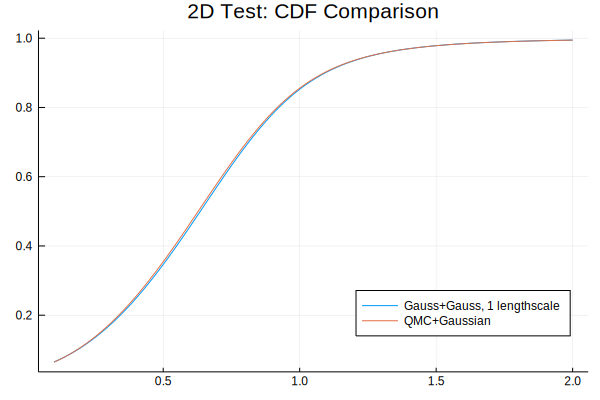

In [111]:
cdf_plot = plot(ygrid, cdf_fixed.(ygrid), label = "Gauss+Gauss, 1 lengthscale", legend=:bottomright)
plot!(ygrid, cdf_fixed2.(ygrid), label = "Gauss+Gauss")
plot!(ygrid, cdf_fixed3.(ygrid), label = "MC+MC")
plot!(ygrid, cdf_fixed4.(ygrid), label = "MC+Gaussian")
plot!(ygrid, cdf_fixed5.(ygrid), label = "QMC+QMC")
plot!(ygrid, cdf_fixed6.(ygrid), label = "QMC+Gaussian", title = "2D Test: CDF Comparison")

In [109]:
range1(q) = quantInfo1[5](x0, Fx0, q)
# range2(q) = quantInfo2[5](x0, Fx0, q)
# range3(q) = quantInfo3[5](x0, Fx0, q)
# range4(q) = quantInfo4[5](x0, Fx0, q)
# range5(q) = quantInfo5[5](x0, Fx0, q)
# range6(q) = quantInfo6[5](x0, Fx0, q)

range1 (generic function with 1 method)

In [117]:
px = 0.5
quant_p1, error_quant1 = quantile(pdf_fixed1, cdf_fixed1, quant01, support1; p=px)

(0.6675501402423699, 0.0)

In [118]:
range1(px)

12×12 Array{Float64,2}:
 -0.205935  -0.191755  -0.171794  …  -0.0850367  -0.0816627  -0.0798353
 -0.154293  -0.157975  -0.159004     -0.100033   -0.0962189  -0.0941384
 -0.390068  -0.370147  -0.339306     -0.168805   -0.161663   -0.157809 
 -0.513869  -0.479801  -0.430362     -0.201916   -0.193222   -0.188543 
 -0.558759  -0.518964  -0.46211      -0.212528   -0.203338   -0.198396 
 -0.573336  -0.531388  -0.471774  …  -0.215069   -0.205752   -0.200745 
 -0.580297  -0.537226  -0.476155     -0.215758   -0.206393   -0.201361 
 -0.585932  -0.541981  -0.479751     -0.21622    -0.206809   -0.201755 
 -0.591085  -0.546365  -0.483112     -0.216684   -0.207227   -0.202148 
 -0.595453  -0.550098  -0.485995     -0.217107   -0.207608   -0.202509 
 -0.59868   -0.552861  -0.488138  …  -0.217432   -0.207902   -0.202786 
 -0.600539  -0.554454  -0.489375     -0.217623   -0.208074   -0.202949 

In [99]:
t = LocationScale(0.3, 1.2, TDist(5))

LocationScale{Float64,TDist{Float64}}(
μ: 0.3
σ: 1.2
ρ: TDist{Float64}(ν=5.0)
)


In [100]:
pp = Distributions.quantile(t, px)

1.4034525362889914

In [112]:
θ = Array{Float64, 1}(undef, 1)
θ[1] = btg1.nodesWeightsθ.nodes[1]

1.630647510776896

In [113]:
λ = Array{Float64, 1}(undef, 1)
λ[1] = btg1.nodesWeightsλ.nodes[1]

0.22581511205459326

In [93]:
DistributionInfo = summary_comp(pdf_fixed1, cdf_fixed1, dpdf_fixed1, quant01, support1; px = .8);

ArgumentError: ArgumentError: The interval [a,b] is not a bracketing interval.
You need f(a) and f(b) to have different signs (f(a) * f(b) < 0).
Consider a different bracket or try fzero(f, c) with an initial guess c.

